<a href="https://colab.research.google.com/github/FranciscoLuna/curso_ICE_STM32CUBEIDE/blob/master/IMDB_y_RNR_entrenamiento%2C_evaluacion_y_descarga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de sentimientos con Redes Neuronales Recurrentes

In [ ]:
# Antes de nada, importamos las librerías que nos puedan hacer falta

import tensorflow as tf # Para crear modelos de Aprendizaje Profundo 

import matplotlib.pyplot as plt # Para graficar imágenes y gráficas de evaluación

import numpy as np # Nos permite trabajar con estructuras vectoriales eficientes
                   # que son además las que emplea tensorflow 

import math # Operaciones matemáticas

# métodos para calcular métricas y matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report 

import itertools # funciones eficientes sobre elementos iterables

## El dataset: opiniones de IMDB


### Configurar parámetros del dataset

In [ ]:
number_of_words = 20000
max_len = 100

### Carga del dataset de IMDB

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=number_of_words)

17465344/17464789 [==============================] - 0s 0us/step


### Cortar secuencias de texto de la misma longitud

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)

In [ ]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

### Configurar parámetros de la capa de Embedding

In [ ]:
vocab_size = number_of_words
vocab_size

20000

In [ ]:
embed_size = 128

## Creando dos tipos de Redes Neuronales Recurrentes con compuertas: LSTM y GRU

### Red Neuronal Recurrente con unidades LSTM

In [ ]:
model_lstm = tf.keras.Sequential()

# Capa Embedding: vectoriza las palabras, determinando cualidades de
# parentezco y relación entre palabras, de forma que palabras relacionadas
# en semántica pasen a ser traducidos como vectores próximos entre ellos
model_lstm.add(tf.keras.layers.Embedding(vocab_size, embed_size, input_shape=(X_train.shape[1],)))

# Una capa LSTM de 128 nodos y con función de activación tangente hiperbólica
model_lstm.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

# Entrenaremos a la red para que determine si un mensaje es positivo o negativo
# Por ello, la capa final estará formada por un único nodo, de modo que valores
# próximos a cero o a uno determinarán si el mensaje es negativo o positivo, 
# respectivamente
model_lstm.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### Compilar el modelo

In [ ]:
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


#### Entrenando el modelo

In [ ]:
model_lstm.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
196/196 [==============================] - 5s 27ms/step - loss: 0.4567 - accuracy: 0.7892
Epoch 2/5
196/196 [==============================] - 5s 26ms/step - loss: 0.2868 - accuracy: 0.8841
Epoch 3/5
196/196 [==============================] - 5s 27ms/step - loss: 0.2320 - accuracy: 0.9119
Epoch 4/5
196/196 [==============================] - 6s 28ms/step - loss: 0.1856 - accuracy: 0.9312
Epoch 5/5
196/196 [==============================] - 5s 28ms/step - loss: 0.1524 - accuracy: 0.9447


#### Evaluando el modelo

El modo más básico de evaluar un modelo de clasificación es a partir de la métrica de precisión o accuracy. 

In [ ]:
# Cálculo de la precisión con el método evaluate del modelo, empleando el subconjunto de prueba
model_lstm.evaluate(X_test,  y_test, verbose=2)

782/782 - 3s - loss: 0.4342 - accuracy: 0.8446


[0.4342467486858368, 0.8445600271224976]

Se pueden emplear otro tipo de métricas. Podemos obtener algunas con la ayuda de la librería para Inteligencia Artificial Scikit Learn

In [ ]:
logits_lstm = np.round(predicts_lstm).reshape((predicts_lstm.shape[0]))

In [ ]:
print(classification_report(y_test, logits_lstm,
                              target_names=['negativo', 'positivo']))

              precision    recall  f1-score   support

    negativo       0.83      0.86      0.85     12500
    positivo       0.86      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



In [ ]:
def otras_metricas(logits, ground_truth, classes):
  logits = np.argmax(logits, axis=1)
  print(classification_report(ground_truth, logits,
                              target_names=classes))

In [ ]:
# Llamamos al modelo para que calcule las clasificaciones con el subconjunto de
# prueba
predicts_lstm = model_lstm.predict(x_test)

# Hallamos las métricas
otras_metricas(predicts_lstm, y_test, classes=['negativo', 'positivo'])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



No obstante, si es interesante saber que la mayor parte de estas métricas se calculan a partir de datos que quedan reflejados en lo que es denominado una **matriz de confusión**, la cual ilustra la cantidad de aciertos y fallos cometidos por el modelo, de forma desglosada. 

Vamos a mostrar esta matriz para el modelo entrenado.

In [ ]:
# Función que convierte las salidas del modelo en una clase, para que pueda ser 
# asimilado por la función de cálculo de la matriz de confusión de SciKit Learn
def confusion_matrix_binary(logits, ground_truth):
  
  logits = np.argmax(logits, axis=1)
  
  cm = confusion_matrix(ground_truth, logits)

  return cm


# Una función para hacer más atractiva e intuitiva la matriz de confusión
def plot_pretty_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.rcParams["figure.figsize"] = (len(classes)*3,len(classes)*3)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Etiquetas del dataset')
  plt.xlabel('Predicciones/clasificación del modelo')


Normalized confusion matrix


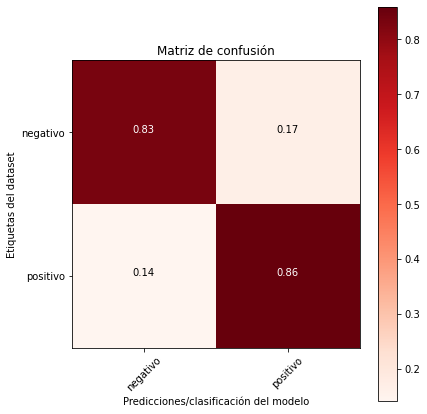

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm_lstm = confusion_matrix(logits_lstm, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm_lstm, classes=['negativo', 'positivo'],
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

### Red Neuronal Recurrente con unidades GRU

In [ ]:
model_gru = tf.keras.Sequential()

# Capa Embedding: vectoriza las palabras, determinando cualidades de
# parentezco y relación entre palabras, de forma que palabras relacionadas
# en semántica pasen a ser traducidos como vectores próximos entre ellos
model_gru.add(tf.keras.layers.Embedding(vocab_size, embed_size, input_shape=(X_train.shape[1],)))

# Una capa GRU de 128 nodos y con función de activación tangente hiperbólica
model_gru.add(tf.keras.layers.GRU(units=128, activation='tanh'))

# Entrenaremos a la red para que determine si un mensaje es positivo o negativo
# Por ello, la capa final estará formada por un único nodo, de modo que valores
# próximos a cero o a uno determinarán si el mensaje es negativo o positivo, 
# respectivamente
model_gru.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### Compilar el modelo

In [ ]:
model_gru.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,659,201
Trainable params: 2,659,201
Non-trainable params: 0
_________________________________________________________________


#### Entrenando el modelo

In [ ]:
model_gru.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
196/196 [==============================] - 5s 26ms/step - loss: 0.4722 - accuracy: 0.7670
Epoch 2/5
196/196 [==============================] - 5s 25ms/step - loss: 0.3020 - accuracy: 0.8752
Epoch 3/5
196/196 [==============================] - 5s 26ms/step - loss: 0.2372 - accuracy: 0.9064
Epoch 4/5
196/196 [==============================] - 5s 26ms/step - loss: 0.1927 - accuracy: 0.9273
Epoch 5/5
196/196 [==============================] - 5s 25ms/step - loss: 0.1535 - accuracy: 0.9450


#### Evaluando el modelo

El modo más básico de evaluar un modelo de clasificación es a partir de la métrica de precisión o accuracy. 

In [ ]:
# Llamamos al modelo para que calcule las clasificaciones con el subconjunto de
# prueba
predicts_gru = model_gru.predict(X_test)

In [ ]:
# Cálculo de la precisión con el método evaluate del modelo, empleando el subconjunto de prueba
model_gru.evaluate(X_test,  y_test, verbose=2)

782/782 - 3s - loss: 0.4494 - accuracy: 0.8320


[0.4494389593601227, 0.8320000171661377]

Se pueden emplear otro tipo de métricas. Podemos obtener algunas con la ayuda de la librería para Inteligencia Artificial Scikit Learn

In [ ]:
logits_gru = np.round(predicts_gru).reshape((predicts_gru.shape[0]))

In [ ]:
print(classification_report(y_test, logits_gru,
                              target_names=['negativo', 'positivo']))

              precision    recall  f1-score   support

    negativo       0.91      0.74      0.81     12500
    positivo       0.78      0.93      0.85     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



No obstante, si es interesante saber que la mayor parte de estas métricas se calculan a partir de datos que quedan reflejados en lo que es denominado una **matriz de confusión**, la cual ilustra la cantidad de aciertos y fallos cometidos por el modelo, de forma desglosada. 

Vamos a mostrar esta matriz para el modelo entrenado.

In [ ]:
# Función que convierte las salidas del modelo en una clase, para que pueda ser 
# asimilado por la función de cálculo de la matriz de confusión de SciKit Learn
def confusion_matrix_binary(logits, ground_truth):
  
  logits = np.argmax(logits, axis=1)
  
  cm = confusion_matrix(ground_truth, logits)

  return cm


# Una función para hacer más atractiva e intuitiva la matriz de confusión
def plot_pretty_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.rcParams["figure.figsize"] = (len(classes)*3,len(classes)*3)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Etiquetas del dataset')
  plt.xlabel('Predicciones/clasificación del modelo')


Normalized confusion matrix


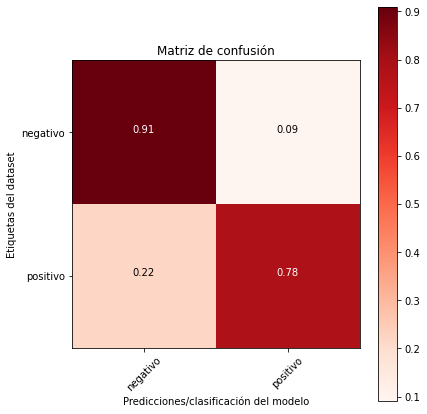

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm_gru = confusion_matrix(logits_gru, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm_gru, classes=['negativo', 'positivo'],
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

## ¿Te animas a continuar? 

Con lo anterior ya tenemos un modelo a nuestra disposición. Sin embargo, quedan una serie de pasos por realizar para trabajar y exprimir las utilidades de CUBE IDE. En concreto, falta por realizar:

1. **Esencial**: descargar el modelo de Keras para embeberlo en CUBE-AI. ***Nota***: recuerda que puede haber problemas de versiones, por lo que es recomendable hacer un downgrade de la versión de Tensorflow.

2. **Interesante e ilustrativo, extraer el dataset**: La extracción del dataset para poder hacer una evaluación meticulosa del modelo embebido. Recuerda que ha de descargarse en csv y con una forma adecuada para que sea asimilable por la herramienta.

3. **Para sacar el máximo provecho, cuantizar**: Tratar de cuantizar el modelo. Si queremos aprovechar al máximo las bondades de la herramienta y mejorar la eficiencia de nuestro sistema embebido, la labor de cuantizar es casi imperativa, sobre todo con placas de bajo consumo. Esta es una buena meta a alcanzar.
